# Evidence curve as a function of time

This notebook examines how well the evidence curve can help us constrain the start time of a QNM. We consider an ideal case where a $(l=2,m=2,n=0)$ mode is injected into white noise.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.rc = {'figure.figsize': (50, 40)}


In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import copy
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


### Construct the GW strain from numerical relativity

In [3]:
#创建实例
NRwaveform = qnm_filter.SXSWaveforms(filename="SXS:BBH:0063")  #传文件名参数，SXSWaveforms是类名
#NRwaveform = qnm_filter.SXSWaveforms(filename="SXS:BBH:0064")  
#NRwaveform = qnm_filter.SXSWaveforms(filename="SXS:BBH:0185")  
#NRwaveform = qnm_filter.SXSWaveforms(filename="SXS:BBH:0305")  


#Get remnant mass and dimensionless spin from SXS catalog
NRwaveform.get_remnant_data()

Found the following files to load from the SXS catalog:
    SXS:BBH:0063v5/Lev5/metadata.json


We focus on $(l=2,m=\pm2)$ harmonics

In [4]:
#Download/Load SXS waveforms
#l=2
NRwaveform.import_sxs_data(l=2, m=2, interpolate=True, delta_t=0.05) #the step size of desired time stamps，interpolate和delta_t需要同时改，否则用sxs默认值，可能间隔不是平均的
NRwaveform.import_sxs_data(l=2, m=-2, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=2, m=1, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=2, m=-1, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=2, m=0, interpolate=True, delta_t=0.05)

"""

#l=3
NRwaveform.import_sxs_data(l=3, m=3, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=3, m=-3, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=3, m=2, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=3, m=-2, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=3, m=1, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=3, m=-1, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=3, m=0, interpolate=True, delta_t=0.05)



#l=4
NRwaveform.import_sxs_data(l=4, m=4, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=4, m=-4, interpolate=True, delta_t=0.05)

#NRwaveform.import_sxs_data(l=4, m=3, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=4, m=-3, interpolate=True, delta_t=0.05)
#
#NRwaveform.import_sxs_data(l=4, m=2, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=4, m=-2, interpolate=True, delta_t=0.05)
#
#NRwaveform.import_sxs_data(l=4, m=1, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=4, m=-1, interpolate=True, delta_t=0.05)

#NRwaveform.import_sxs_data(l=4, m=0, interpolate=True, delta_t=0.05)

#l=5
NRwaveform.import_sxs_data(l=5, m=5, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=5, m=-5, interpolate=True, delta_t=0.05)
#
#NRwaveform.import_sxs_data(l=5, m=4, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=5, m=3, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=5, m=2, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=5, m=1, interpolate=True, delta_t=0.05)
#NRwaveform.import_sxs_data(l=5, m=0, interpolate=True, delta_t=0.05)
"""

NRwaveform.pad_data(partition=2, len_pow=1)  #左右加同样的0

Found the following files to load from the SXS catalog:
    SXS:BBH:0063v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0063v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [5]:
luminous_intensity = 440 # in Mpc
bbh_mass = 72 # BBH's initial total mass, distinguished from remmnant mass
NRwaveform.scale_to_si("padded_data", bbh_mass, luminous_intensity)


### Construct detector noise with `bilby`

In [6]:
sampling_frequency = 16384 # in Hz
duration = 16 # in second

acf_time = np.arange(0, 1., 1./sampling_frequency)
acf_value = acf_time*0
acf_value[0] = 1e-44                                 #给初始值赋值的目的？

In [7]:
noise_customize = qnm_filter.Noise(acf = acf_value, time = acf_time)
noise_customize.from_acf()

Below we construct two `bilby.gw.detector.Interferometer` instances for comparision. One is noisy and the other one is noiseless.

In [8]:
bilby_ifo = qnm_filter.set_bilby_ifo(noise_customize, sampling_frequency, duration, -duration/2, 0,8192)
print(bilby_ifo.minimum_frequency)
bilby_ifo_no_noise = qnm_filter.set_bilby_ifo(noise_customize, sampling_frequency, duration, 
                                                         -duration/2, 0,8192, zero_noise=True)
print(bilby_ifo_no_noise.minimum_frequency)


0
0


<AxesSubplot:>

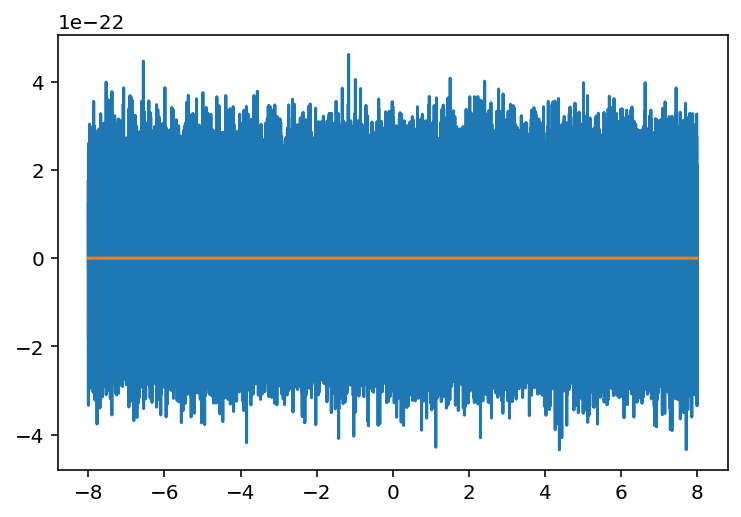

In [9]:
signalH_noise = qnm_filter.bilby_get_strain(bilby_ifo, 0.0)
signalH_no_noise = qnm_filter.bilby_get_strain(bilby_ifo_no_noise, 0.0)
signalH_noise.plot()
signalH_no_noise.plot()

### Inject the GW strain into noise

In [10]:
def NR_injection_into_Bilby(time, iota, beta, **waveform_kwargs):
    """A waveform function for `bilby.gw.waveform_generator.WaveformGenerator`
    
    Parameters
    ----------
    time : ndarray
        time stamps for waveform
    iota : float
        inclination angle, in radian.
    beta : float
        azimuth, in radian.
        
    Returns
    -------
    Dictionary
        A dictionary for plus and cross polarizations.
    """
    nr_dataset = NRwaveform.harmonics_to_polarizations("data_in_si", iota, beta, [(2,2), (2,-2)])
    hplus = nr_dataset['plus']
    hcross = nr_dataset['cross']
    hplus_interp_func = interp1d(hplus.time, hplus.values, bounds_error=False, fill_value=0)
    hcross_interp_func = interp1d(hcross.time, hcross.values, bounds_error=False, fill_value=0)

    hplus = hplus_interp_func(time)     #time = getattr(self, attr_name)[str(l) + str(m)].time
    hcross = hcross_interp_func(time)   

    return {'plus': hplus, 'cross': hcross}

In [39]:
bbh_spin1 = NRwaveform.get_bbh_spin1
bbh_spin2 = NRwaveform.get_bbh_spin2
injection_parameters = dict(mass_1=bbh_mass*NRwaveform.get_bbh_m1, mass_2=bbh_mass*NRwaveform.get_bbh_m2,
                            spin_1x=bbh_spin1[0], spin_1y=bbh_spin1[1], spin_1z=bbh_spin1[2],
                            spin_2x=bbh_spin2[0], spin_2y=bbh_spin2[1], spin_2z=bbh_spin2[2],
                            geocent_time=-duration/2,
                            iota=0, beta=0, 
                            ra=0, dec=0, psi=0, NRwaveform=NRwaveform)  #输入NR信号

bilby_ifo.minimum_frequency = 10  #SimInspiralTaylorF2ReducedSpinChirpTime函数的频率输入应该位于范围 [10, 8192] Hz。这个范围是基于引力波信号的常见频率范围。
bilby_ifo_no_noise.minimum_frequency = 10


Found the following files to load from the SXS catalog:
    SXS:BBH:0063v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0063v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0063v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0063v5/Lev5/metadata.json


In [40]:
bilby_ifo_inj = qnm_filter.bilby_injection(bilby_ifo, NR_injection_into_Bilby, **injection_parameters)
bilby_ifo_inj_no_noise = qnm_filter.bilby_injection(bilby_ifo_no_noise, NR_injection_into_Bilby, 
                                                    **injection_parameters)

16:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.NR_injection_into_Bilby
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:29 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distance'
16:29 bilby INFO    : Injected signal in None:
16:29 bilby INFO    :   optimal SNR = 186.49
16:29 bilby INFO    :   matched filter SNR = 185.34+1.21j
16:29 bilby INFO    :   mass_1 = 64.000022797368
16:29 bilby INFO    :   mass_2 = 8.000033566392
16:29 bilby INFO    :   spin_1x = 1.26635047766e-09
16:29 bilby INFO    :   spin_1y = -1.48897378e-10
16:29 bilby INFO    :   spin_1z = 2.0682688609e-07
16:29 bilby INFO    :   spin_2x = -9.27878134584e-11


-3.297732    0.0+0.0j
-3.297714    0.0+0.0j
-3.297697    0.0+0.0j
-3.297679    0.0+0.0j
-3.297661    0.0+0.0j
               ...   
 1.350456    0.0+0.0j
 1.350474    0.0+0.0j
 1.350491    0.0+0.0j
 1.350509    0.0+0.0j
 1.350527    0.0+0.0j
Length: 262144, dtype: complex128
-3.297732    0.0+0.0j
-3.297714    0.0+0.0j
-3.297697    0.0+0.0j
-3.297679    0.0+0.0j
-3.297661    0.0+0.0j
               ...   
 1.350456    0.0+0.0j
 1.350474    0.0+0.0j
 1.350491    0.0+0.0j
 1.350509    0.0+0.0j
 1.350527    0.0+0.0j
Length: 262144, dtype: complex128


16:29 bilby INFO    :   spin_2y = 6.08100712406e-11
16:29 bilby INFO    :   spin_2z = 4.29282215789e-07
16:29 bilby INFO    :   geocent_time = -8.0
16:29 bilby INFO    :   iota = 0
16:29 bilby INFO    :   beta = 0
16:29 bilby INFO    :   ra = 0
16:29 bilby INFO    :   dec = 0
16:29 bilby INFO    :   psi = 0
16:29 bilby INFO    :   NRwaveform = <qnm_filter.sxs_helper.SXSWaveforms object at 0x7feb20920ca0>
16:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.NR_injection_into_Bilby
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:29 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distance'
16:29 bilby INFO    : Injected signal in None:
16:29 bilby INFO    :   optimal SNR = 186.49
16:29 bilby INFO    :   matched filter SNR = 186.49+0.00j
16:29 bilby INFO    :   mass_1 = 64.000022797368
16:29 bilby INFO    :   mass_2 = 8.000033566392


-3.297732    0.0+0.0j
-3.297714    0.0+0.0j
-3.297697    0.0+0.0j
-3.297679    0.0+0.0j
-3.297661    0.0+0.0j
               ...   
 1.350456    0.0+0.0j
 1.350474    0.0+0.0j
 1.350491    0.0+0.0j
 1.350509    0.0+0.0j
 1.350527    0.0+0.0j
Length: 262144, dtype: complex128
-3.297732    0.0+0.0j
-3.297714    0.0+0.0j
-3.297697    0.0+0.0j
-3.297679    0.0+0.0j
-3.297661    0.0+0.0j
               ...   
 1.350456    0.0+0.0j
 1.350474    0.0+0.0j
 1.350491    0.0+0.0j
 1.350509    0.0+0.0j
 1.350527    0.0+0.0j
Length: 262144, dtype: complex128


In [41]:
# t0 = qnm_filter.time_shift_from_sky(bilby_ifo.name ,injection_parameters['ra'], injection_parameters['dec'], 0.0)
t0 = bilby_ifo.time_delay_from_geocenter(injection_parameters['ra'], injection_parameters['dec'], 0.0)

In [42]:
signalH = qnm_filter.bilby_get_strain(bilby_ifo_inj, t0)
signalH_no_noise = qnm_filter.bilby_get_strain(bilby_ifo_inj_no_noise, t0)

(-0.1, 0.1)

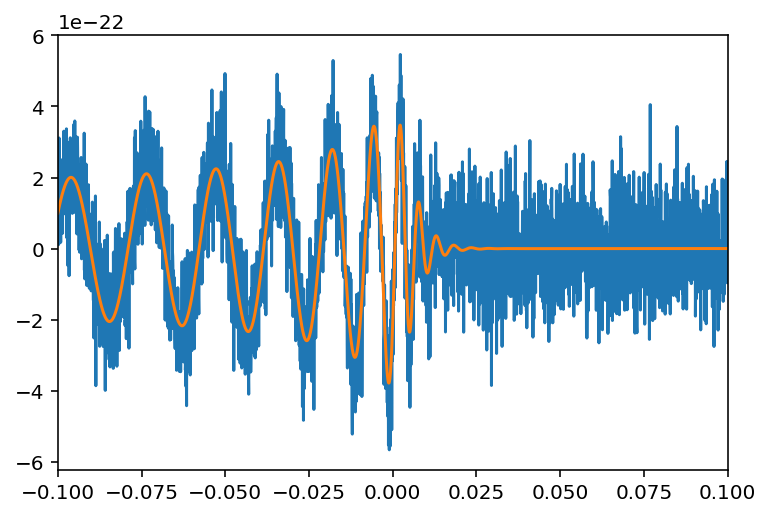

In [43]:
signalH.plot()
signalH_no_noise.plot()
#signalH_noise.plot()
pl.xlim(-0.1,0.1)

### Ringdown analysis with rational filter(s)

In [44]:
fit = qnm_filter.Network(segment_length=0.2, srate=4096, t_init = 0.0025)

In [45]:
fit.original_data['H1'] = signalH
fit.detector_alignment()    # shifted_time = self.t_init

In [46]:
fit.pure_noise = {}  #fit的新属性
fit.pure_noise['H1'] = signalH_noise

In [47]:
fit.pure_nr= {}
fit.pure_nr['H1'] = signalH_no_noise  #NR

We use the Welch method to estimate the covariance matrix with pure noise. The estimation with `original_data` may break down when SNR is large enough

In [48]:
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.condition_data('pure_nr')
fit.compute_acfs('pure_noise')

In [49]:
fit.cholesky_decomposition()

Sampling remnant mass and spin

In [50]:
delta_mass = 1.0
delta_chi = 0.01
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [51]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, 
                                                 num_cpu = -1, model_list = [(2, 2, 0, "p"),(3, 3, 0, "p")]) #,(2, 2, 1, "p"),(2, 1, 0, "p"),,(2, 2, 1, "p")
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [52]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)


In [53]:
"""
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=NRwaveform.mf*bbh_mass, y=NRwaveform.chif, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')
"""

'\npl.rc(\'figure\', figsize=(6.1, 6.6))\nfig, ax = pl.subplots()\ncontours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap=\'Spectral\',\n                       origin=\'lower\', alpha=0.6, linestyles=\'--\')\ndotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = \'red\',                    linestyles =\'--\')\nax.scatter(x=NRwaveform.mf*bbh_mass, y=NRwaveform.chif, s=255, marker=\'+\', \n           c=\'g\', linewidths=4, label=\'IMR\')\n\n\n# coloarbar\ncbar=fig.colorbar(contours, orientation="horizontal", \n                  pad=0.15, format=\'%3.2f\')\ncbar.set_label(r\'$\\ln$ likelihood\', fontsize=15)\ncbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))\n\npl.xlabel(r\'$M_f/M_\\odot$\', fontsize=13)\npl.ylabel(r\'$\\chi_f$\', fontsize=13)\n\n# ax.set_title(r\'$\\mathcal{F}_{220}+\\mathcal{F}_{221}$\')\n'

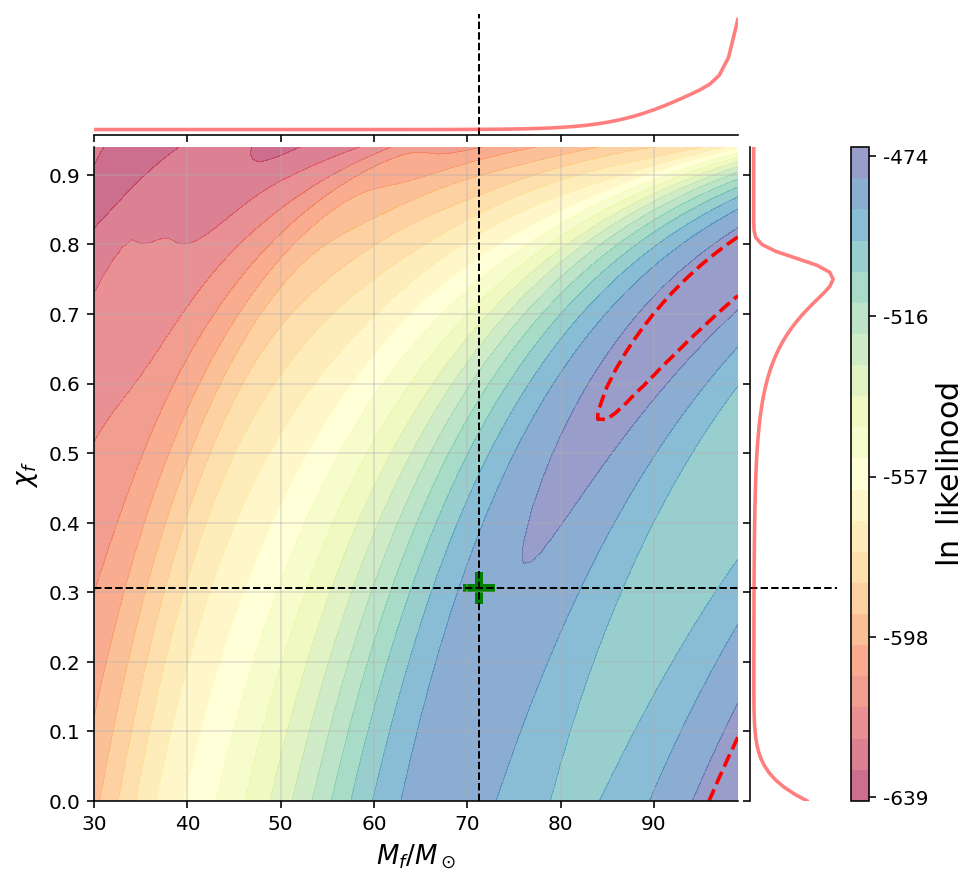

In [54]:
g = sns.JointGrid(ratio=5,space=0.1)

#改质量和自旋(x，y)
# 2D
contours=g.ax_joint.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
g.ax_joint.contour(contours, levels=[credible_region], linewidths=1.8,
                   linestyles='--', colors='red')
g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
g.ax_joint.yaxis.set_major_locator(MultipleLocator(0.1))
g.ax_joint.scatter(x=71.24, y=0.3067, s=255, marker='+', 
                   c='g', linewidths=4, label='IMR')
g.ax_joint.axvline(71.24, ls='--', lw=1, c='k')
g.ax_joint.axhline(0.3067, ls='--', lw=1, c='k')    
g.ax_joint.set_xlabel(r'$M_f/M_\odot$', fontsize=13)
g.ax_joint.set_ylabel(r'$\chi_f$', fontsize=13)
g.ax_joint.grid(alpha=0.4)

# 1D side plots 
g.ax_marg_x.axvline(71.24, ls='--', lw=1, c='k')
g.ax_marg_x.plot(massspace, projected_mass, color='r', lw=1.8, alpha=0.5)

g.ax_marg_y.axhline(0.3067, ls='--', lw=1, c='k')
g.ax_marg_y.plot(projected_chi, chispace, color='r',lw=1.8,alpha=0.5)

# coloarbar
divider = make_axes_locatable(g.ax_marg_y)
cax = divider.append_axes('right', size='20%', pad=0.1)
cbar=g.fig.colorbar(contours, cax=cax, orientation="vertical", format='%3.0f', ax=g.ax_marg_y)
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

In [55]:
fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], fit.truncate_data(fit.pure_nr)['H1'], 'H1', False)

18.270096556592215

Compute the first index of the analysis segment

In [ ]:
"""
fit.first_index()
index_spacing = 2
initial_offset, num_iteration = qnm_filter.time_to_index(fit, index_spacing, -0.002, 0.005)   #选取不同的开始分析时间对evidence的影响
"""

In [ ]:
#fitnew=copy.deepcopy(fit)  #？？

Iterate over `t_init`

In [ ]:
"""
t_array, saved_log_evidence220p = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p")])

t_array, saved_log_evidence220p220r = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                          verbosity=False, model_list = [(2, 2, 0, "p"),(2, 2, 0, "r")])
 

t_array, saved_log_evidence220p330p = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(3, 3, 0, "p")])
t_array, saved_log_evidence220p320p = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(3, 2, 0, "p")])
t_array, saved_log_evidence220p210p = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(2, 1, 0, "p")])
t_array, saved_log_evidence220p440p = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(4, 4, 0, "p")])


t_array, saved_log_evidence220p221p = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(2, 2, 1, "p")])

t_array, saved_log_evidence220p221p222p = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(2, 2, 1, "p"),(2, 2, 2, "p")])                                                           
t_array, saved_log_evidence220p221p220r = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(2, 2, 1, "p"),(2, 2, 0, "r")])
t_array, saved_log_evidence220p221p220r221r = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0, "p"),(2, 2, 1, "p"),(2, 2, 1, "r"),(2, 2, 0, "r")])
"""                                                

In [ ]:
"""
t_array_no_filter, saved_log_evidence_no_filter = qnm_filter.evidence_parallel(fitnew, index_spacing, num_iteration, 
                                                                               initial_offset, massspace, chispace, 
                                                                               num_cpu = -1, verbosity=False, 
                                                                               apply_filter=False, 
                                                                               model_list = [(2, 2, 0)])   #不加filter怎么还提供model_list?"""

In the absence of the filter, the curve goes up when the ringdown signal slides off the analysis segment, namely $t>t_{\rm start\, time}$. In contrast, the filter flips the ringdown to the oppsite side, causing the evidence curve to rise sooner and plateau when $t>t_{\rm start\, time}$.

In [ ]:
"""
saved_log_evidence220p /= np.log(10) # ln to lg
#saved_log_evidence220p220r /= np.log(10) # ln to lg

#saved_log_evidence220p330p /= np.log(10) # ln to lg
#saved_log_evidence220p320p /= np.log(10) # ln to lg
#saved_log_evidence220p210p /= np.log(10) # ln to lg
#saved_log_evidence220p440p /= np.log(10) # ln to lg

#saved_log_evidence220p221p /= np.log(10) # ln to lg
#saved_log_evidence220p221p222p /= np.log(10) # ln to lg
#saved_log_evidence220p221p220r /= np.log(10) # ln to lg
#saved_log_evidence220p221p220r221r /= np.log(10) # ln to lg


saved_log_evidence_no_filter /= np.log(10)"""

In [ ]:
"""
pl.plot(t_array, saved_log_evidence220p, 'o', ms=1.5, label='w/ filter220p')
#pl.plot(t_array, saved_log_evidence220p220r, 'o', ms=1.5, label='w/ filter220p220r')

#pl.plot(t_array, saved_log_evidence220p330p, 'o', ms=1.5, label='w/ filter220p330p')
#pl.plot(t_array, saved_log_evidence220p320p, 'o', ms=1.5, label='w/ filter220p320p')
#pl.plot(t_array, saved_log_evidence220p210p, 'o', ms=1.5, label='w/ filter220p210p')
#pl.plot(t_array, saved_log_evidence220p440p, 'o', ms=1.5, label='w/ filter220p440p')

#pl.plot(t_array, saved_log_evidence220p221p, 'o', ms=1.5, label='w/ filter220p221p')
#pl.plot(t_array, saved_log_evidence220p221p222p, 'o', ms=1.5, label='w/ filter220p221p222p')
#pl.plot(t_array, saved_log_evidence220p220r, 'o', ms=1.5, label='w/ filter220p221p220r')

#pl.plot(t_array, saved_log_evidence220p221p220r, 'o', ms=1.5, label='w/ filter220p221p220r')
#pl.plot(t_array, saved_log_evidence220p221p220r221r, 'o', ms=1.5, label='w/ filter220p221p220r221r')

pl.plot(t_array_no_filter, saved_log_evidence_no_filter, 'o', ms=1.5, label="w/o filter")

pl.axvline(0, ls='--', label='start time')
pl.legend()
pl.ylabel('lg Evidence')
pl.xlabel('t (ms)')
"""

The difference between the two evidence curves leads to the Bayes factor of the QNM, which peaks at its start time.

In [ ]:
"""
pl.plot(t_array, saved_log_evidence220p-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p')
#pl.plot(t_array, saved_log_evidence220p220r-saved_log_evidence220p, 'o', ms=1.5, label='w/ filter220p220r')

#pl.plot(t_array, saved_log_evidence220p330p-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p330p')
#pl.plot(t_array, saved_log_evidence220p320p-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p320p')
#pl.plot(t_array, saved_log_evidence220p210p-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p210p')
#pl.plot(t_array, saved_log_evidence220p440p-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p440p')

#pl.plot(t_array, saved_log_evidence220p221p-saved_log_evidence220p, 'o', ms=1.5, label='w/ filter220p221p')

#pl.plot(t_array, saved_log_evidence220p221p222p-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p221p222p')
#pl.plot(t_array, saved_log_evidence220p221p220r-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p220r221p')
#pl.plot(t_array, saved_log_evidence220p221p220r221r-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter220p220r221p221r')

pl.axvline(0, ls='--', label='start time')
pl.legend()
pl.ylabel('lg Bayes')
pl.xlabel('t (ms)')
"""